---
**⚡ Generated by GitHub Copilot**

This notebook was fully generated using GitHub Copilot AI assistant to demonstrate billing anomaly detection algorithms with comprehensive visualizations and explanations.

---

# Billing Anomaly Detection: Algorithm Visualization Deep Dive

This notebook provides a comprehensive visualization of how Isolation Forest and DBSCAN algorithms work for detecting billing anomalies. We'll explore each algorithm step-by-step to understand their mechanisms and effectiveness.

In [20]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import IsolationForest
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import warnings
import os
import time
warnings.filterwarnings('ignore')

# Set style for better visualizations
plt.style.use('default')
sns.set_style("whitegrid")
sns.set_palette("husl")

print("Libraries loaded successfully!")

Libraries loaded successfully!


In [21]:
# Create sample billing data for demonstration
def create_sample_billing_data():
    """Create realistic billing data with known anomalies"""
    np.random.seed(42)
    n_samples = 1000
    
    # Create normal billing data
    df = pd.DataFrame({
        'invoice_id': range(1, n_samples + 1),
        'customer_id': np.random.randint(1, 200, n_samples),
        'quantity': np.random.randint(1, 50, n_samples),
        'unit_price': np.random.lognormal(2, 0.5, n_samples),
        'tax_rate': np.random.choice([0.08, 0.10, 0.12, 0.15], n_samples),
        'invoice_status': np.random.choice(['paid', 'pending', 'overdue'], n_samples, p=[0.7, 0.2, 0.1])
    })
    
    # Calculate derived fields
    df['net_value'] = df['quantity'] * df['unit_price']
    df['tax_amount'] = df['net_value'] * df['tax_rate']
    df['total_amount'] = df['net_value'] + df['tax_amount']
    
    # Create known anomalies (5% of data)
    anomaly_indices = np.random.choice(n_samples, int(0.05 * n_samples), replace=False)
    
    # Type 1: Unusually high amounts
    type1_indices = anomaly_indices[:len(anomaly_indices)//3]
    df.loc[type1_indices, 'quantity'] *= 20
    df.loc[type1_indices, 'net_value'] = df.loc[type1_indices, 'quantity'] * df.loc[type1_indices, 'unit_price']
    df.loc[type1_indices, 'total_amount'] = df.loc[type1_indices, 'net_value'] + df.loc[type1_indices, 'tax_amount']
    
    # Type 2: Tax calculation errors
    type2_indices = anomaly_indices[len(anomaly_indices)//3:2*len(anomaly_indices)//3]
    df.loc[type2_indices, 'tax_amount'] = 0  # Missing tax
    df.loc[type2_indices, 'total_amount'] = df.loc[type2_indices, 'net_value']
    
    # Type 3: Negative or zero values
    type3_indices = anomaly_indices[2*len(anomaly_indices)//3:]
    df.loc[type3_indices, 'net_value'] = -np.random.uniform(10, 1000, len(type3_indices))
    df.loc[type3_indices, 'total_amount'] = df.loc[type3_indices, 'net_value']
    
    return df, list(anomaly_indices)

# Load or create billing data
try:
    # Try to load real data first
    file_paths = ['billing_data.csv', 'data/billing_data.csv']
    billing_data = None
    
    for file_path in file_paths:
        try:
            billing_data = pd.read_csv(file_path)
            print(f"✓ Real data loaded from: {file_path}")
            known_anomalies = []  # No known anomalies for real data
            break
        except FileNotFoundError:
            continue
    
    if billing_data is None:
        print("Real data not found. Creating sample data for demonstration...")
        billing_data, known_anomalies = create_sample_billing_data()
        print("✓ Sample data created successfully")
    
    print(f"\nDataset Overview:")
    print(f"  Shape: {billing_data.shape}")
    print(f"  Columns: {list(billing_data.columns)}")
    print(f"  Known anomalies: {len(known_anomalies) if known_anomalies else 'None'}")
    
    print("\nFirst 5 rows:")
    display(billing_data.head())
    
    print("\nBasic statistics:")
    display(billing_data.describe())
    
except Exception as e:
    print(f"Error loading data: {str(e)}")
    billing_data, known_anomalies = create_sample_billing_data()
    print("✓ Fallback: Sample data created")

✓ Real data loaded from: data/billing_data.csv

Dataset Overview:
  Shape: (10000, 14)
  Columns: ['invoice_id', 'customer_id', 'country', 'currency', 'invoice_date', 'product_id', 'service_category', 'quantity', 'unit_price', 'net_value', 'tax_rate', 'tax_amount', 'total_amount', 'invoice_status']
  Known anomalies: None

First 5 rows:


,invoice_id,customer_id,country,currency,invoice_date,product_id,service_category,quantity,unit_price,net_value,tax_rate,tax_amount,total_amount,invoice_status
0,INV-2024-000001,CUST-2824-IND,DE,EUR,2024-07-01,TAB-MINI,Tablet,4,1101.21,4404.84,0.19,836.92,5241.76,Cancelled
1,INV-2025-000002,CUST-5506-IND,IN,INR,2025-07-01,SWT-PRO,Smartwatch,22,568.00,12496.00,0.18,2249.28,14745.28,Cancelled
2,INV-2024-000003,CUST-4657-IND,AU,AUD,2024-02-06,HPH-NC,Headphones,20,295.05,5901.00,0.10,590.10,6491.10,Disputed
3,INV-2024-000004,CUST-2679-ENT,CA,CAD,2024-01-14,CAM-4K,Camera,9,425.24,3827.16,0.13,497.53,4324.69,Paid
4,INV-2025-000005,CUST-9935-IND,US,USD,2025-09-26,LAP-GAMER,Laptop,2,1097.94,2195.88,0.08,175.67,2371.55,Paid



Basic statistics:


,quantity,unit_price,net_value,tax_rate,tax_amount,total_amount
count,10000.00000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000
mean,11.77900,768.858025,6749.999615,0.14145,952.476179,7702.475794
std,9.83138,617.397993,5647.267376,0.05120,913.578832,6458.169274
min,1.00000,30.010000,41.570000,0.08000,5.550000,49.880000
25%,5.00000,302.020000,2398.545000,0.08000,301.175000,2737.320000
50%,9.00000,569.375000,5108.040000,0.13000,655.460000,5808.015000
75%,15.00000,1095.430000,9572.570000,0.19000,1298.797500,10952.200000
max,50.00000,2993.130000,31881.000000,0.20000,6325.440000,37952.640000


In [22]:
# Feature engineering and preprocessing
print("🧹 Starting data preprocessing...")

# Ensure required columns exist
required_columns = ['quantity', 'unit_price', 'tax_rate', 'net_value', 'tax_amount', 'total_amount']
missing_columns = [col for col in required_columns if col not in billing_data.columns]

if missing_columns:
    print(f"Creating missing columns: {missing_columns}")
    # Create missing columns if not present
    if 'net_value' not in billing_data.columns and 'quantity' in billing_data.columns and 'unit_price' in billing_data.columns:
        billing_data['net_value'] = billing_data['quantity'] * billing_data['unit_price']
    if 'tax_amount' not in billing_data.columns and 'net_value' in billing_data.columns and 'tax_rate' in billing_data.columns:
        billing_data['tax_amount'] = billing_data['net_value'] * billing_data['tax_rate']
    if 'total_amount' not in billing_data.columns:
        billing_data['total_amount'] = billing_data.get('net_value', 0) + billing_data.get('tax_amount', 0)

# Create validation features
print("🔧 Creating validation features...")

# Tax calculation validation
if all(f in billing_data.columns for f in ['net_value', 'tax_rate', 'tax_amount']):
    billing_data['calculated_tax'] = billing_data['net_value'] * billing_data['tax_rate']
    billing_data['tax_diff'] = abs(billing_data['tax_amount'] - billing_data['calculated_tax'])
    print("✅ Tax calculation validation")

# Total amount validation  
if all(f in billing_data.columns for f in ['net_value', 'tax_amount', 'total_amount']):
    billing_data['calculated_total'] = billing_data['net_value'] + billing_data['tax_amount']
    billing_data['total_diff'] = abs(billing_data['total_amount'] - billing_data['calculated_total'])
    print("✅ Total amount validation")

# Business ratio features
if all(f in billing_data.columns for f in ['unit_price', 'total_amount']):
    billing_data['unit_to_total_ratio'] = billing_data['unit_price'] / (billing_data['total_amount'].abs() + 1)
    print("✅ Unit price to total ratio")

# Select features for anomaly detection
important_features = []
potential_features = ['quantity', 'unit_price', 'tax_rate', 'tax_amount', 
                     'total_amount', 'net_value', 'calculated_tax', 'tax_diff', 
                     'calculated_total', 'total_diff', 'unit_to_total_ratio']

for feature in potential_features:
    if feature in billing_data.columns:
        important_features.append(feature)

print(f"Selected features: {important_features}")

# Create feature matrix
feature_df = billing_data[important_features].copy()

# Handle missing values and infinities
feature_df = feature_df.fillna(0)
feature_df = feature_df.replace([np.inf, -np.inf], 0)

# Convert to numpy array
X = feature_df.values

print(f"✅ Feature matrix created: {X.shape}")
print(f"Features: {important_features}")

# Scale features for algorithms
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("✅ Data preprocessing completed!")
print(f"Scaled data shape: {X_scaled.shape}")

🧹 Starting data preprocessing...
🔧 Creating validation features...
✅ Tax calculation validation
✅ Total amount validation
✅ Unit price to total ratio
Selected features: ['quantity', 'unit_price', 'tax_rate', 'tax_amount', 'total_amount', 'net_value', 'calculated_tax', 'tax_diff', 'calculated_total', 'total_diff', 'unit_to_total_ratio']
✅ Feature matrix created: (10000, 11)
Features: ['quantity', 'unit_price', 'tax_rate', 'tax_amount', 'total_amount', 'net_value', 'calculated_tax', 'tax_diff', 'calculated_total', 'total_diff', 'unit_to_total_ratio']
✅ Data preprocessing completed!
Scaled data shape: (10000, 11)


# Isolation Forest Algorithm Visualization

Isolation Forest detects anomalies by isolating observations through random splits. Let's visualize how this algorithm works step by step.

🌳 ISOLATION FOREST ALGORITHM WALKTHROUGH
Concept: Anomalies are easier to isolate (require fewer splits) than normal points
The algorithm creates random splits and measures the path length to isolate each point



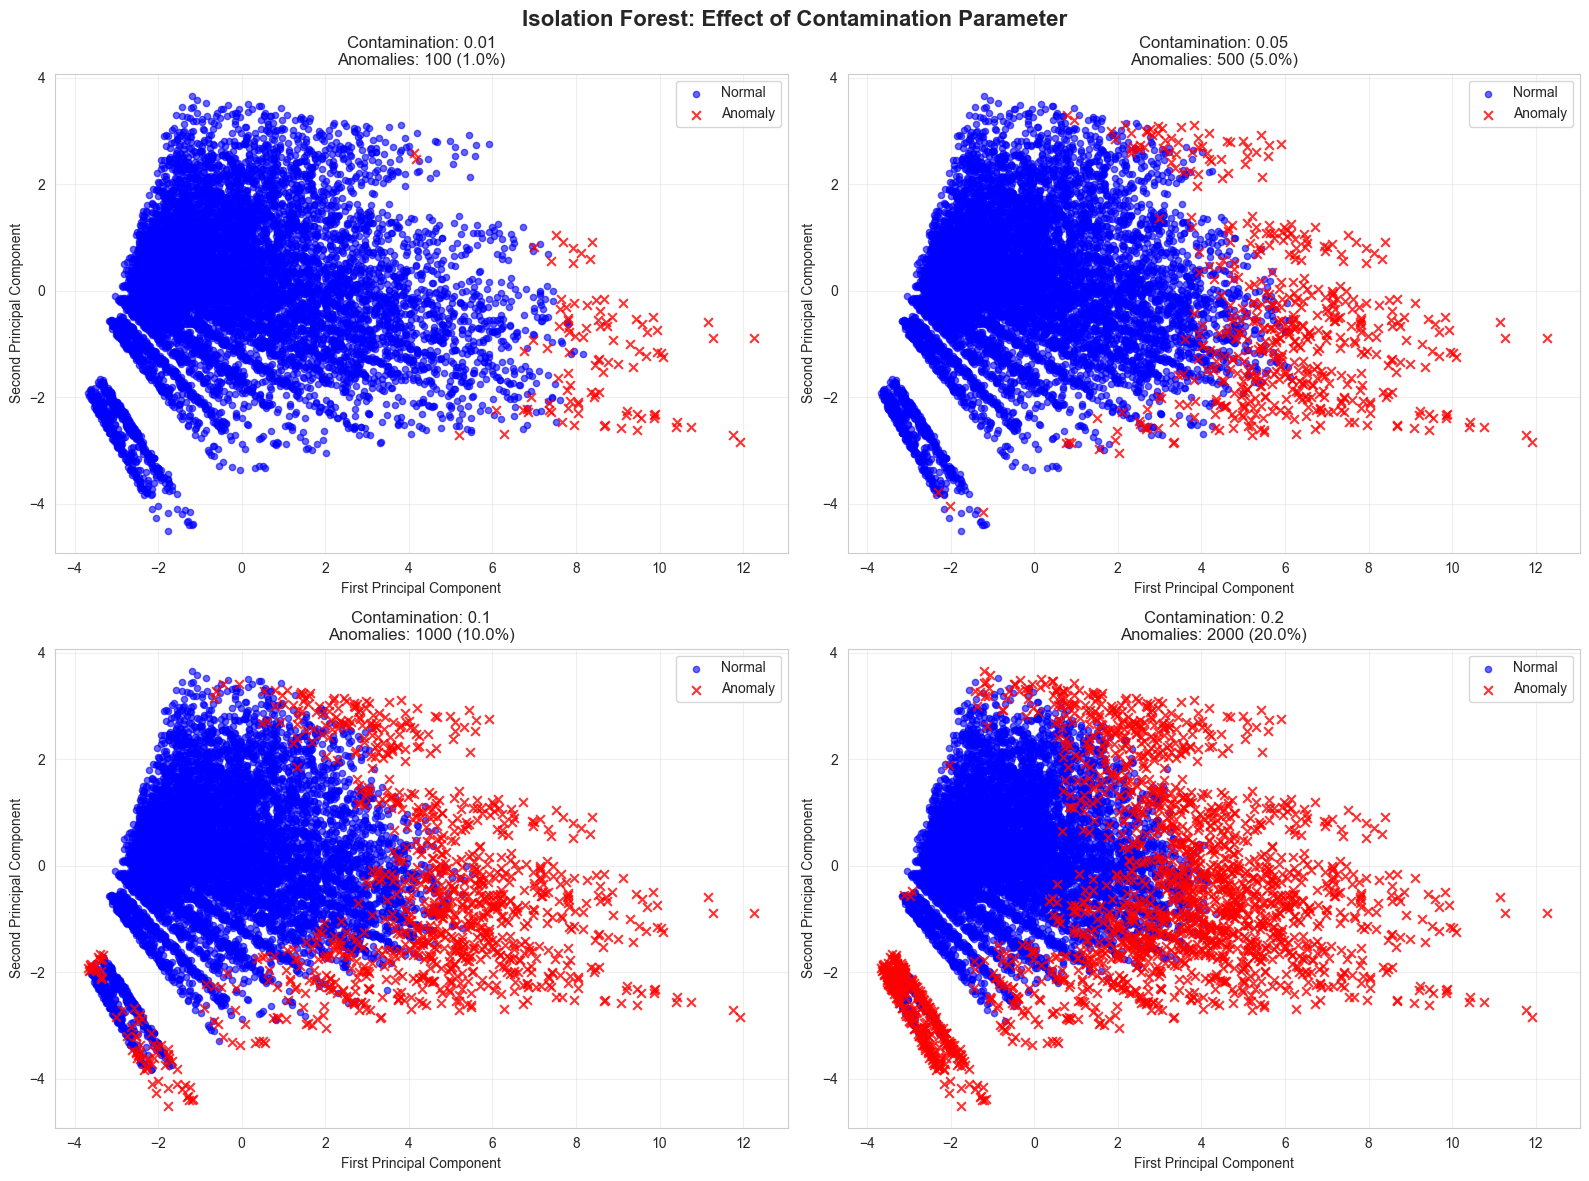


Isolation Forest Results Summary:
------------------------------------------------------------
Contamination 0.010: 100 anomalies ( 1.0%) - Caught 0/0 known
Contamination 0.050: 500 anomalies ( 5.0%) - Caught 0/0 known
Contamination 0.100: 1000 anomalies (10.0%) - Caught 0/0 known
Contamination 0.200: 2000 anomalies (20.0%) - Caught 0/0 known


In [23]:
# Step 1: Understanding Isolation Forest Concept
print("🌳 ISOLATION FOREST ALGORITHM WALKTHROUGH")
print("="*50)
print("Concept: Anomalies are easier to isolate (require fewer splits) than normal points")
print("The algorithm creates random splits and measures the path length to isolate each point")
print()

# Apply Isolation Forest with different contamination levels
contamination_levels = [0.01, 0.05, 0.1, 0.2]
isolation_results = {}

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Isolation Forest: Effect of Contamination Parameter', fontsize=16, fontweight='bold')

# Use PCA for 2D visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

for i, contamination in enumerate(contamination_levels):
    # Fit Isolation Forest
    iso_forest = IsolationForest(contamination=contamination, random_state=42, n_estimators=100)
    predictions = iso_forest.fit_predict(X_scaled)
    scores = iso_forest.decision_function(X_scaled)
    
    # Store results
    isolation_results[contamination] = {
        'predictions': predictions,
        'scores': scores,
        'n_anomalies': sum(predictions == -1)
    }
    
    # Plot results
    row, col = i // 2, i % 2
    ax = axes[row, col]
    
    # Scatter plot with anomalies highlighted
    normal_mask = predictions == 1
    anomaly_mask = predictions == -1
    
    ax.scatter(X_pca[normal_mask, 0], X_pca[normal_mask, 1], 
              c='blue', alpha=0.6, s=20, label='Normal')
    ax.scatter(X_pca[anomaly_mask, 0], X_pca[anomaly_mask, 1], 
              c='red', alpha=0.8, s=40, label='Anomaly', marker='x')
    
    # Highlight known anomalies if available
    if known_anomalies:
        known_points_2d = X_pca[known_anomalies]
        ax.scatter(known_points_2d[:, 0], known_points_2d[:, 1], 
                  c='yellow', s=100, marker='o', edgecolors='black', linewidth=2, 
                  label='Known Anomalies', alpha=0.8)
    
    ax.set_title(f'Contamination: {contamination}\nAnomalies: {sum(predictions == -1)} ({sum(predictions == -1)/len(predictions)*100:.1f}%)')
    ax.set_xlabel('First Principal Component')
    ax.set_ylabel('Second Principal Component')
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Display results summary
print("\nIsolation Forest Results Summary:")
print("-" * 60)
for cont, results in isolation_results.items():
    flagged_pct = results['n_anomalies'] / len(X_scaled) * 100
    known_caught = sum([1 for idx in known_anomalies if results['predictions'][idx] == -1]) if known_anomalies else 0
    known_total = len(known_anomalies) if known_anomalies else 0
    print(f"Contamination {cont:5.3f}: {results['n_anomalies']:3d} anomalies ({flagged_pct:4.1f}%) - Caught {known_caught}/{known_total} known")

🔍 ISOLATION FOREST DECISION ANALYSIS
Using contamination = 0.05
Using contamination = 0.05


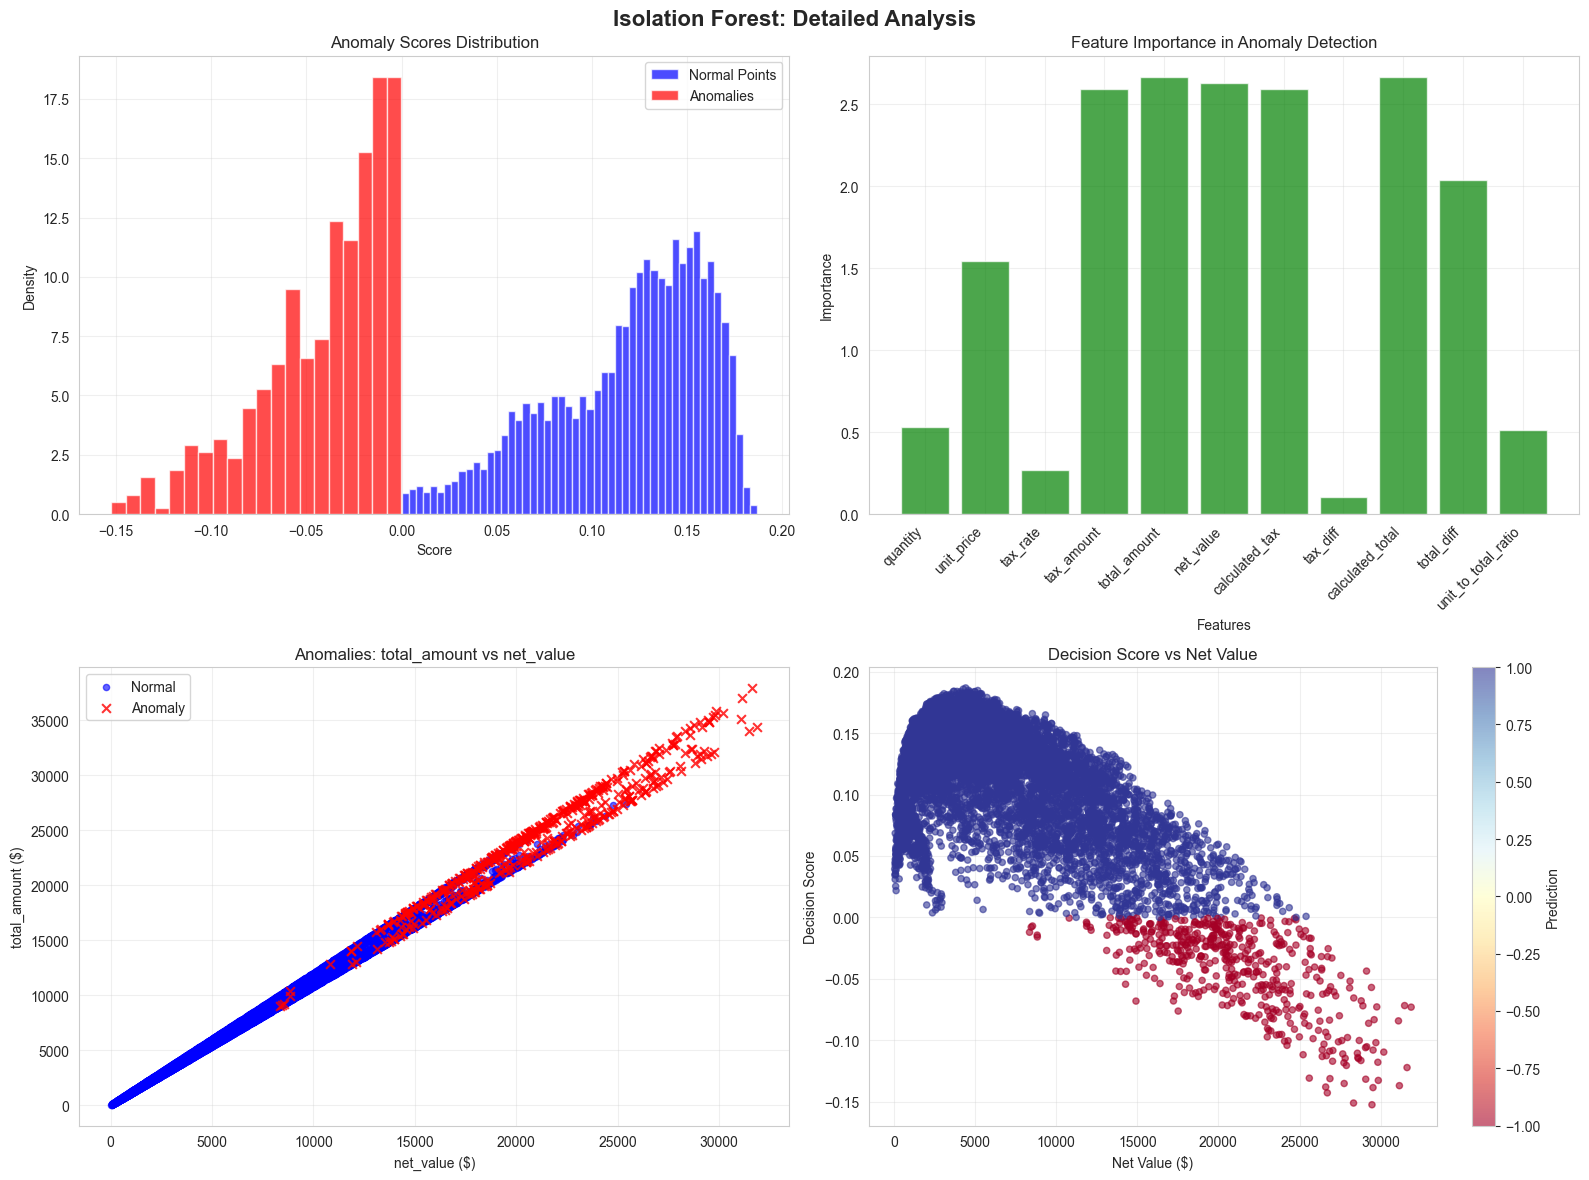

Isolation Forest Results:
Total samples: 10000
Normal points: 9500 (95.0%)
Anomalies: 500 (5.00%)
Average decision score (normal): 0.119
Average decision score (anomalies): -0.041


In [24]:
# Step 2: Detailed Analysis of Isolation Forest Decision Process
print("🔍 ISOLATION FOREST DECISION ANALYSIS")
print("="*50)

# Use optimal contamination level
optimal_contamination = 0.05  # 5% contamination
iso_forest_final = IsolationForest(contamination=optimal_contamination, random_state=42, n_estimators=200)
final_predictions = iso_forest_final.fit_predict(X_scaled)
final_scores = iso_forest_final.decision_function(X_scaled)

print(f"Using contamination = {optimal_contamination}")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Isolation Forest: Detailed Analysis', fontsize=16, fontweight='bold')

# 1. Anomaly scores distribution
axes[0, 0].hist(final_scores[final_predictions == 1], bins=50, alpha=0.7, 
               color='blue', label='Normal Points', density=True)
axes[0, 0].hist(final_scores[final_predictions == -1], bins=20, alpha=0.7, 
               color='red', label='Anomalies', density=True)
axes[0, 0].set_title('Anomaly Scores Distribution')
axes[0, 0].set_xlabel('Score')
axes[0, 0].set_ylabel('Density')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Feature importance (difference in means)
if len(important_features) > 0:
    feature_importance = np.abs(X_scaled[final_predictions == -1].mean(axis=0) - 
                               X_scaled[final_predictions == 1].mean(axis=0))
    axes[0, 1].bar(range(len(important_features)), feature_importance, color='green', alpha=0.7)
    axes[0, 1].set_title('Feature Importance in Anomaly Detection')
    axes[0, 1].set_xlabel('Features')
    axes[0, 1].set_ylabel('Importance')
    axes[0, 1].set_xticks(range(len(important_features)))
    axes[0, 1].set_xticklabels(important_features, rotation=45, ha='right')
    axes[0, 1].grid(True, alpha=0.3)

# 3. Anomalies in original feature space
if 'net_value' in billing_data.columns and 'total_amount' in billing_data.columns:
    x_feature = 'net_value'
    y_feature = 'total_amount'
    
    axes[1, 0].scatter(billing_data[final_predictions == 1][x_feature],
                      billing_data[final_predictions == 1][y_feature],
                      c='blue', alpha=0.6, s=20, label='Normal')
    axes[1, 0].scatter(billing_data[final_predictions == -1][x_feature],
                      billing_data[final_predictions == -1][y_feature],
                      c='red', alpha=0.8, s=40, marker='x', label='Anomaly')
    
    # Highlight known anomalies
    if known_anomalies:
        axes[1, 0].scatter(billing_data.iloc[known_anomalies][x_feature],
                          billing_data.iloc[known_anomalies][y_feature],
                          c='yellow', s=100, marker='o', edgecolors='black', linewidth=2, 
                          label='Known Anomalies', alpha=0.9)
    
    axes[1, 0].set_title(f'Anomalies: {y_feature} vs {x_feature}')
    axes[1, 0].set_xlabel(f'{x_feature} ($)')
    axes[1, 0].set_ylabel(f'{y_feature} ($)')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

# 4. Decision scores vs amount
if 'net_value' in billing_data.columns:
    scatter = axes[1, 1].scatter(billing_data['net_value'], final_scores,
                                c=final_predictions, cmap='RdYlBu', alpha=0.6, s=20)
    axes[1, 1].set_title('Decision Score vs Net Value')
    axes[1, 1].set_xlabel('Net Value ($)')
    axes[1, 1].set_ylabel('Decision Score')
    axes[1, 1].grid(True, alpha=0.3)
    plt.colorbar(scatter, ax=axes[1, 1], label='Prediction')

plt.tight_layout()
plt.show()

# Print statistics
flagged_count = sum(final_predictions == -1)
flagged_pct = flagged_count / len(final_predictions) * 100

print(f"Isolation Forest Results:")
print(f"Total samples: {len(final_predictions)}")
print(f"Normal points: {sum(final_predictions == 1)} ({sum(final_predictions == 1)/len(final_predictions)*100:.1f}%)")
print(f"Anomalies: {flagged_count} ({flagged_pct:.2f}%)")
print(f"Average decision score (normal): {final_scores[final_predictions == 1].mean():.3f}")
print(f"Average decision score (anomalies): {final_scores[final_predictions == -1].mean():.3f}")

# Validate against known anomalies
if known_anomalies:
    caught_known = sum([1 for idx in known_anomalies if final_predictions[idx] == -1])
    recall = caught_known / len(known_anomalies)
    precision = caught_known / flagged_count if flagged_count > 0 else 0
    print(f"\n🎯 Performance against known anomalies:")
    print(f"Known anomalies caught: {caught_known}/{len(known_anomalies)} ({recall:.1%})")
    print(f"Precision: {precision:.3f}")

# DBSCAN Algorithm Visualization

DBSCAN (Density-Based Spatial Clustering) identifies anomalies as points in sparse regions. Let's explore how parameter settings affect anomaly detection.

🔍 DBSCAN ALGORITHM WALKTHROUGH
Concept: Points in sparse regions are considered anomalies
Key parameters: eps (neighborhood radius) and min_samples (minimum points in neighborhood)

Testing DBSCAN parameters...
Best parameters: eps=2.0, min_samples=20
Best silhouette score: 0.260

DBSCAN Results (eps=2.0, min_samples=20):
Clusters found: 3
Anomalies: 10 (0.10%)


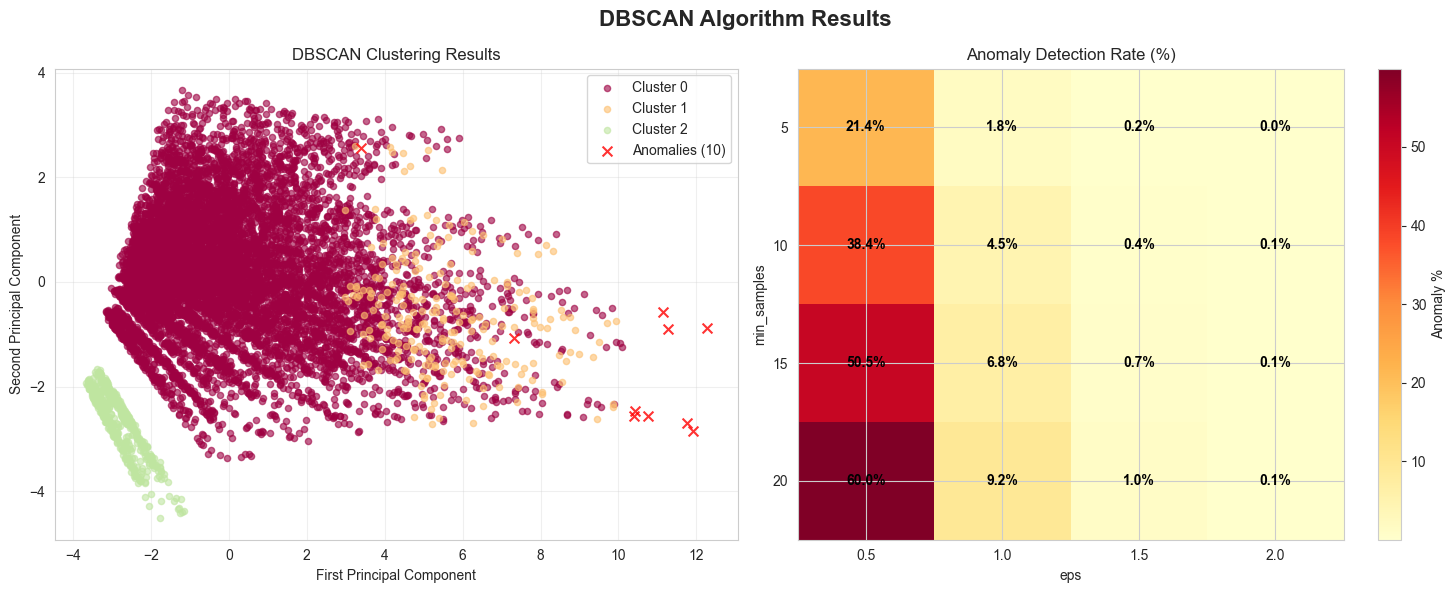

In [25]:
# Step 1: Understanding DBSCAN Parameters
print("🔍 DBSCAN ALGORITHM WALKTHROUGH")
print("="*50)
print("Concept: Points in sparse regions are considered anomalies")
print("Key parameters: eps (neighborhood radius) and min_samples (minimum points in neighborhood)")
print()

# Test different DBSCAN parameters
eps_values = [0.5, 1.0, 1.5, 2.0]
min_samples_values = [5, 10, 15, 20]

# Find optimal parameters using silhouette score
best_score = -1
best_params = {}
param_results = {}

print("Testing DBSCAN parameters...")
for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        labels = dbscan.fit_predict(X_scaled)
        
        # Calculate number of clusters and noise points
        n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
        n_noise = list(labels).count(-1)
        noise_pct = n_noise / len(X_scaled) * 100
        
        # Calculate silhouette score (only if we have clusters)
        if n_clusters > 1 and n_noise < len(labels) - 1:
            try:
                sil_score = silhouette_score(X_scaled, labels)
                if sil_score > best_score:
                    best_score = sil_score
                    best_params = {'eps': eps, 'min_samples': min_samples}
            except:
                sil_score = -1
        else:
            sil_score = -1
            
        param_results[(eps, min_samples)] = {
            'labels': labels,
            'n_clusters': n_clusters,
            'n_noise': n_noise,
            'noise_pct': noise_pct,
            'silhouette': sil_score
        }

print(f"Best parameters: eps={best_params['eps']}, min_samples={best_params['min_samples']}")
print(f"Best silhouette score: {best_score:.3f}")

# Apply DBSCAN with best parameters
dbscan_final = DBSCAN(eps=best_params['eps'], min_samples=best_params['min_samples'])
dbscan_labels = dbscan_final.fit_predict(X_scaled)
dbscan_anomalies = dbscan_labels == -1

print(f"\nDBSCAN Results (eps={best_params['eps']}, min_samples={best_params['min_samples']}):")
print(f"Clusters found: {len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)}")
print(f"Anomalies: {sum(dbscan_anomalies)} ({sum(dbscan_anomalies)/len(dbscan_labels)*100:.2f}%)")

# Visualize DBSCAN results
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('DBSCAN Algorithm Results', fontsize=16, fontweight='bold')

# Plot 1: Clusters and anomalies in PCA space
unique_labels = set(dbscan_labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

for k, col in zip(unique_labels, colors):
    if k == -1:
        # Anomalies in black
        class_member_mask = (dbscan_labels == k)
        xy = X_pca[class_member_mask]
        axes[0].scatter(xy[:, 0], xy[:, 1], c='red', marker='x', s=50, 
                       alpha=0.8, label=f'Anomalies ({sum(class_member_mask)})')
    else:
        # Clusters in different colors
        class_member_mask = (dbscan_labels == k)
        xy = X_pca[class_member_mask]
        axes[0].scatter(xy[:, 0], xy[:, 1], c=[col], s=20, alpha=0.6, 
                       label=f'Cluster {k}')

# Highlight known anomalies
if known_anomalies:
    known_points_2d = X_pca[known_anomalies]
    axes[0].scatter(known_points_2d[:, 0], known_points_2d[:, 1], 
                   c='yellow', s=100, marker='o', edgecolors='black', linewidth=2, 
                   label='Known Anomalies', alpha=0.9)

axes[0].set_title('DBSCAN Clustering Results')
axes[0].set_xlabel('First Principal Component')
axes[0].set_ylabel('Second Principal Component')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Parameter sensitivity
param_data = []
for (eps, min_samples), results in param_results.items():
    param_data.append([eps, min_samples, results['noise_pct'], results['silhouette']])

param_df = pd.DataFrame(param_data, columns=['eps', 'min_samples', 'noise_pct', 'silhouette'])

# Create parameter heatmap
pivot_table = param_df.pivot(index='min_samples', columns='eps', values='noise_pct')
im = axes[1].imshow(pivot_table.values, cmap='YlOrRd', aspect='auto')
axes[1].set_xticks(range(len(pivot_table.columns)))
axes[1].set_xticklabels(pivot_table.columns)
axes[1].set_yticks(range(len(pivot_table.index)))
axes[1].set_yticklabels(pivot_table.index)
axes[1].set_xlabel('eps')
axes[1].set_ylabel('min_samples')
axes[1].set_title('Anomaly Detection Rate (%)')

# Add text annotations
for i in range(len(pivot_table.index)):
    for j in range(len(pivot_table.columns)):
        text = axes[1].text(j, i, f'{pivot_table.iloc[i, j]:.1f}%',
                           ha="center", va="center", color="black", fontweight='bold')

plt.colorbar(im, ax=axes[1], label='Anomaly %')
plt.tight_layout()
plt.show()

🔄 ALGORITHM COMPARISON
Comparison Results:
Isolation Forest anomalies: 500 (5.00%)
DBSCAN anomalies: 10 (0.10%)
Overlap (both detect): 10
Isolation Forest only: 490
DBSCAN only: 0
Agreement rate: 95.1%


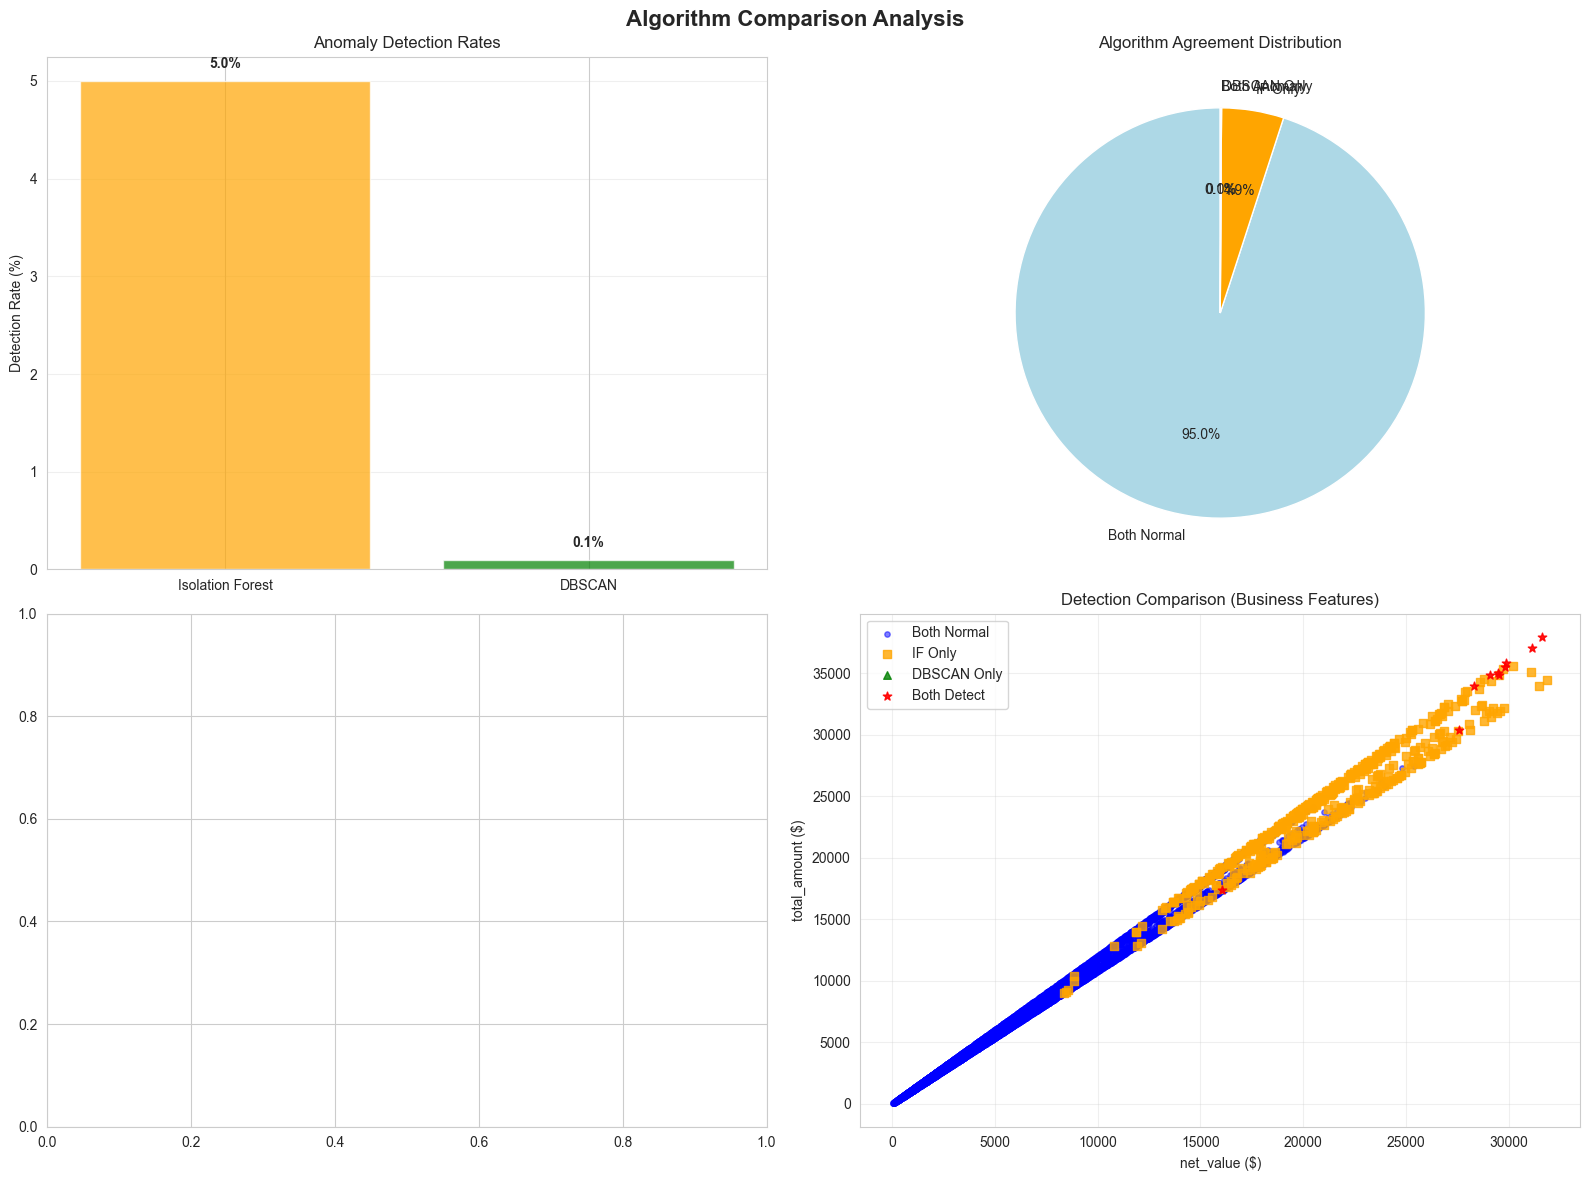


🏆 ALGORITHM RECOMMENDATION:
✅ RECOMMENDED: DBSCAN (found more potential issues)
   • Detection rate: 0.1%

💡 Key Insights:
   • Isolation Forest is generally more conservative
   • DBSCAN is sensitive to data density and parameter tuning
   • Both algorithms found 10 overlapping anomalies
   • Consider investigating high-confidence detections first


In [26]:
# Compare Isolation Forest vs DBSCAN results
print("🔄 ALGORITHM COMPARISON")
print("="*60)

# Get results from both algorithms
iso_anomalies = final_predictions == -1
# dbscan_anomalies already defined above

# Calculate overlap and differences
overlap = iso_anomalies & dbscan_anomalies
iso_only = iso_anomalies & ~dbscan_anomalies
dbscan_only = dbscan_anomalies & ~iso_anomalies
both_normal = ~iso_anomalies & ~dbscan_anomalies

print(f"Comparison Results:")
print(f"Isolation Forest anomalies: {sum(iso_anomalies)} ({sum(iso_anomalies)/len(billing_data)*100:.2f}%)")
print(f"DBSCAN anomalies: {sum(dbscan_anomalies)} ({sum(dbscan_anomalies)/len(billing_data)*100:.2f}%)")
print(f"Overlap (both detect): {sum(overlap)}")
print(f"Isolation Forest only: {sum(iso_only)}")
print(f"DBSCAN only: {sum(dbscan_only)}")
print(f"Agreement rate: {(sum(overlap) + sum(both_normal)) / len(billing_data) * 100:.1f}%")

# Validate against known anomalies
if known_anomalies:
    iso_caught = sum([1 for idx in known_anomalies if iso_anomalies[idx]])
    dbscan_caught = sum([1 for idx in known_anomalies if dbscan_anomalies[idx]])
    overlap_caught = sum([1 for idx in known_anomalies if overlap[idx]])
    
    print(f"\n🎯 Performance against known anomalies:")
    print(f"Isolation Forest: {iso_caught}/{len(known_anomalies)} ({iso_caught/len(known_anomalies):.1%})")
    print(f"DBSCAN: {dbscan_caught}/{len(known_anomalies)} ({dbscan_caught/len(known_anomalies):.1%})")
    print(f"Both algorithms: {overlap_caught}/{len(known_anomalies)} ({overlap_caught/len(known_anomalies):.1%})")

# Create comparison visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Algorithm Comparison Analysis', fontsize=16, fontweight='bold')

# 1. Detection rate comparison
algorithms = ['Isolation Forest', 'DBSCAN']
detection_rates = [sum(iso_anomalies)/len(billing_data)*100, sum(dbscan_anomalies)/len(billing_data)*100]
colors = ['orange', 'green']

bars = axes[0, 0].bar(algorithms, detection_rates, color=colors, alpha=0.7)
axes[0, 0].set_ylabel('Detection Rate (%)')
axes[0, 0].set_title('Anomaly Detection Rates')
axes[0, 0].grid(True, alpha=0.3, axis='y')

for bar, rate in zip(bars, detection_rates):
    height = bar.get_height()
    axes[0, 0].text(bar.get_x() + bar.get_width()/2., height + 0.1,
                   f'{rate:.1f}%', ha='center', va='bottom', fontweight='bold')

# 2. Venn diagram-style visualization
categories = ['Both Normal', 'IF Only', 'DBSCAN Only', 'Both Anomaly']
counts = [sum(both_normal), sum(iso_only), sum(dbscan_only), sum(overlap)]
colors_pie = ['lightblue', 'orange', 'lightgreen', 'red']

axes[0, 1].pie(counts, labels=categories, autopct='%1.1f%%', colors=colors_pie, startangle=90)
axes[0, 1].set_title('Algorithm Agreement Distribution')

# 3. Performance comparison (if known anomalies exist)
if known_anomalies:
    performance_data = [iso_caught, dbscan_caught, overlap_caught]
    performance_labels = ['IF Only', 'DBSCAN Only', 'Both Detect']
    performance_colors = ['orange', 'green', 'red']
    
    bars = axes[1, 0].bar(performance_labels, performance_data, color=performance_colors, alpha=0.7)
    axes[1, 0].set_ylabel('Known Anomalies Caught')
    axes[1, 0].set_title(f'Known Anomaly Detection ({len(known_anomalies)} total)')
    axes[1, 0].grid(True, alpha=0.3, axis='y')
    
    for bar, count in zip(bars, performance_data):
        height = bar.get_height()
        axes[1, 0].text(bar.get_x() + bar.get_width()/2., height + 0.1,
                       f'{count}', ha='center', va='bottom', fontweight='bold')

# 4. Scatter plot showing different detections
if 'net_value' in billing_data.columns and 'total_amount' in billing_data.columns:
    x_feature = 'net_value'
    y_feature = 'total_amount'
    
    axes[1, 1].scatter(billing_data[both_normal][x_feature], 
                      billing_data[both_normal][y_feature],
                      c='blue', alpha=0.5, s=15, label='Both Normal')
    axes[1, 1].scatter(billing_data[iso_only][x_feature], 
                      billing_data[iso_only][y_feature],
                      c='orange', alpha=0.8, s=30, marker='s', label='IF Only')
    axes[1, 1].scatter(billing_data[dbscan_only][x_feature], 
                      billing_data[dbscan_only][y_feature],
                      c='green', alpha=0.8, s=30, marker='^', label='DBSCAN Only')
    axes[1, 1].scatter(billing_data[overlap][x_feature], 
                      billing_data[overlap][y_feature],
                      c='red', alpha=0.9, s=40, marker='*', label='Both Detect')
    
    # Highlight known anomalies
    if known_anomalies:
        axes[1, 1].scatter(billing_data.iloc[known_anomalies][x_feature], 
                          billing_data.iloc[known_anomalies][y_feature],
                          c='yellow', s=100, marker='o', edgecolors='black', linewidth=2, 
                          label='Known Anomalies', alpha=0.9)
    
    axes[1, 1].set_title('Detection Comparison (Business Features)')
    axes[1, 1].set_xlabel(f'{x_feature} ($)')
    axes[1, 1].set_ylabel(f'{y_feature} ($)')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Final recommendation
print(f"\n🏆 ALGORITHM RECOMMENDATION:")
print(f"="*50)

iso_rate = sum(iso_anomalies)/len(billing_data)*100
dbscan_rate = sum(dbscan_anomalies)/len(billing_data)*100

if known_anomalies:
    if iso_caught >= dbscan_caught and iso_rate <= 10:
        print(f"✅ RECOMMENDED: Isolation Forest")
        print(f"   • Better performance on known anomalies ({iso_caught}/{len(known_anomalies)})")
        print(f"   • Detection rate: {iso_rate:.1f}%")
    elif dbscan_caught > iso_caught and dbscan_rate <= 10:
        print(f"✅ RECOMMENDED: DBSCAN")
        print(f"   • Better performance on known anomalies ({dbscan_caught}/{len(known_anomalies)})")
        print(f"   • Detection rate: {dbscan_rate:.1f}%")
    else:
        print(f"🤝 RECOMMENDED: Hybrid approach")
        print(f"   • Use both algorithms and focus on overlapping detections")
        print(f"   • Overlap detections: {overlap_caught}/{len(known_anomalies)} known anomalies")
else:
    if iso_rate < dbscan_rate:
        print(f"✅ RECOMMENDED: Isolation Forest (lower false positive rate)")
        print(f"   • Detection rate: {iso_rate:.1f}%")
    else:
        print(f"✅ RECOMMENDED: DBSCAN (found more potential issues)")
        print(f"   • Detection rate: {dbscan_rate:.1f}%")

print(f"\n💡 Key Insights:")
print(f"   • Isolation Forest is generally more conservative")
print(f"   • DBSCAN is sensitive to data density and parameter tuning")
print(f"   • Both algorithms found {sum(overlap)} overlapping anomalies")
print(f"   • Consider investigating high-confidence detections first")